# Méthodes de Monte Carlo

Pour les deux algorithmes vus précédemment (itération sur les valeurs et itération sur les politiques), on devrait connaître le modèle de transition $p(s'|s,a)$ et le modèle de récompense $r(s,a)$. Dans ce notebook, on va explorer les méthodes de Monte Carlo qui ne nécessitent pas la connaissance de ces mmodèles. Seule l'expérience va guider le choix. 

Pour cela, on va se placer dans des PDMs épisodiques, c'est-à-dire que chaque épisode doit se terminer et on va apprendre d'un épisode en entier.

1. [Exemple du Black Jack (simplifié)](#sec1)
2. [Evaluation d'une politique](#sec2)
3. [On-policy Monte Carlo](#sec3)
4. [Bonus - FrozenLake](#sec4)

## <a name="sec1">1. Exemple du Black Jack (simplifié)</a>

On considère une version simplifiée du jeu de Blackjack où le but est d'accumuler des cartes dont la somme des points ne doit pas dépasser 21. Les figures valent 10 points, les cartes numérotées valent le numéro de la carte. Il y a une complication avec l'as qui peut être vue comme valant 1 point (comme un 1) ou comme un 11 (un as). Ici, on va jouer contre un croupier qui a une stratégie fixée.
* Au départ du jeu, le croupier et le joueur possèdent deux cartes. Le joueur peut observer ses deux cartes, mais ne peut observer qu'une seule carte du croupier.
* Si le joueur a déjà 21 points, la partie s'arrête et soit le joueur gagne, soit le match est nul si le croupier a aussi 21 points. 
* Si le joueur n'a pas 21 points, il peut décider de rester (stick 0) ou bien il peut demander une nouvelle carte (hit 1) de façon répétée.
* Quand le joueur décide de s'arrêter, le dealer peut à son tour s'arrêter ou demander des nouvelles cartes. Ici, on va supposer que ce choix se fait selon une stratégie fixe : il s'arrête dès qu'il a 17 point ou plus, il demande une carte dans le cas contraire.
* Si un joueur dépasse 21 points en demandant une carte, il perd la partie
* Si les deux joueurs se sont arrêtés, c'est celui dont la somme des cartes est plus proche de 21 qui remporte la partie.

On fait l'hypothèse que le croupier tire les cartes dans une pile infinie (avec remplacement).

Si le joueur possède un as qu'il peut utiliser comme 1 ou 11 sans dépasser 21, on dit qu'il a un as utilisable.

L'état du jeu peut être décrit par un triplet :
* la somme de points courante (dont on pourrait restreindre l'intervalle à [12-21])
* la valeur de la carte du croupier
* la possession ou non d'un as utilisable

La récompense immédiate après chaque action est :
* 0 si le partie continue
* -1 si le joueur perd
* +1 si le joueur gagne

On va modéliser avec un taux d'escompte $\gamma=1$.

[OpenAI gym](https://gym.openai.com/) est un environnement pour tester et comparer des algorithmes d'apprentissage par renforcement. 


In [1]:
# Import useful modules
import numpy as np
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm import tqdm 
from collections import defaultdict

# Set up openAi Gym
import gym
from gym import envs
env = gym.make("Blackjack-v0") # Colab
# env = gym.make("Blackjack-v1") # Local jupyter
num_actions = env.action_space.n
print(env.observation_space)

Tuple(Discrete(32), Discrete(11), Discrete(2))


In [2]:
env.reset()
env.action_space

Discrete(2)

In [3]:
env.reset()

(7, 4, False)

In [4]:
env.step(1)

((16, 4, False), 0.0, False, {})

In [5]:
env.step(0)

((16, 4, False), 1.0, True, {})

L'état du jeu de blackjack est donc décrit par un triplet $(s_1, s_2, a)$ où $s_1$ est la somme des points contenus dans la main du joueur, $s_2$ est la valeur de la carte visible du croupier, et $a$ est un booléen qui indique si le joueur possède un as utilisable.

Comme vous pouvez le voir dans l'exécution du code ci-dessus, l'espace des états pour ce jeu est encodé comme un triplet, et $s_1$ peut prendre 32 valeurs, $s_2$ peut prendre 11 valeurs. En théorie, on pourrait restreindre $s_1$ a 21 valeurs (au delà de 21 points, on est dans un état final perdant), voir même moins (au deça de 10 points, prendre une carte est sans risque !). Pour faciliter le code, on ne va pas chercher à optimiser l'espace et on va conserver 32 possibilités. 

In [6]:
# max_sum is the maximum sum I can have in my hand
max_sum = 32

# max_opp_score is the maximum value of the card I can see from the opponent
max_opp_score = 11

# number of States
num_states = 32*11*2

print(f'Problem with {num_states} states and {num_actions} actions.')

Problem with 704 states and 2 actions.


Pour essayer d'écrire un code que l'on pourra utiliser pour d'autres problèmes, on vous donne le code pour encoder l'état avec un entier et pour faire l'inverse (i.e. décoder un entier en un état). Ainsi, il vous sera possible d'avoir des tables du style $v(s)$ et $q(s,a)$ où $s$ sera l'index d'un des états du jeu, et $a$ l'index d'une action.

In [7]:
# function to encode or decode a state
#~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~~
# encode a state as an integer
# for blackjack, the state is s=[i,j,b] where
# i is the number of points in my hand i \in [1,31]
# j is the number of points I can observe from the opponent j\in [1,10]
# b is a boolean telling whether I have a usable ace
#
# encode turns the state to an integer, and decode does the opposite

def encode(state):
    if state[2]:
        return state[0] + state[1]*max_sum
    else:
        return state[0] + state[1]*max_sum + max_sum*max_opp_score

def decode(index):
    state = [0, 0, 0]
    if (index > max_sum*max_opp_score):
        state[2] = False
        index = index - max_sum*max_opp_score
    else:
        state[2] = True
        state[0] = index % max_sum
        state[1]= index // max_sum
    return state

## <a name="sec2">2. Evaluation d'une politique fixée $\pi$</a> 

On va tout d'abord évaluer une politique fixée $\pi$ avec un algorithme de Monte Carlo. La politique que l'on va évaluer est simple : si le joueur à 20 points ou plus, il s'arrête, sinon, il demande une carte. La politique est encodée dans la fonction `strategy()` ci-dessous.

In [8]:
def strategy(state):
    if (state[0] >= 20):
        return 0
    else:
        return 1

### 2.1 Implémentation

Implémentez l'algorithme de Monte Carlo dans sa version "all-visit" pour évaluer une politique (même si un état se répète plusieurs fois sur la trace d'exécution de l'épisode, on met à jour ses statistiques). Cet algorithme est un peu plus simple à implémenter que son variant "first-visit" pour lequel on met à jour un état seulement lors de sa première visite.

Cela dit, dans le cadre de Blackjack, est-ce qu'on aurait une différence ?

La fonction `generate_episode()` permet de générer un épisode en suivant une politique $\pi$.

In [9]:
def generate_episode(env, pi, max_timesteps=100):
    episode = []
    state = env.reset()

    for t in range(max_timesteps):
        action = np.argmax(pi[encode(state)]) # Choose action following policy pi
        new_state, reward, done, _ = env.step(action)
        episode.append((state, action, reward))
        state = new_state
        if done:
            #print("Episode finished after {} timesteps".format(t+1))
            break
            
    return episode

La fonction `policy_evaluation_all_visit()` permet d'apprendre $v_{\pi}$ à partir des épisodes en suivant une politique $\pi$ (apprentissage par expérience).

In [10]:
def policy_evaluation_all_visit(env, pi, gamma=1, num_episodes=100):
    
    # Initialization
    v = np.zeros(num_states)
    count = np.zeros(num_states)
    acc = np.zeros(num_states)
    
    for _ in tqdm(range(num_episodes)):

        # Generate an episode
        episode = generate_episode(env, pi)
        T = len(episode)

        # Initialize return
        G = 0 # G_T = 0

        for t in reversed(range(T)): # From T-1 to 0

            # Follow policy pi
            state, action, reward = episode[t]
            i_state = encode(state)

            # Compute return 
            G = reward + gamma*G # G_t

            # Update v
            acc[i_state] += G
            count[i_state] += 1
            v[i_state] = acc[i_state] / count[i_state] # Avg
        
    return v 

On implémente la fonction `exploitation()` qui permet d'exploiter la politique $\pi$ donnée. Elle renvoie la récompense à long terme par épisode, et la récompense moyenne. La fonction `exploit_and_plot()` appelle la méthode précédente et affiche les récompenses à long terme lissées.

In [11]:
def exploitation(env, pi, gamma, num_episodes):

    # Save return per episode
    episodes_return = []

    # For every episode...
    for _ in tqdm(range(num_episodes)):

        # Generate an episode following policy pi
        episode = generate_episode(env, pi=pi)
        T = len(episode)

        # Initialize return
        G = 0 # G_T = 0

        for t in reversed(range(T)): # From T-1 to 0

            # Follow policy pi
            state, action, reward = episode[t]
            i_state = encode(state)

            # Compute return 
            G = reward + gamma*G # G_t

        episodes_return.append(G) # Append G_0
        
    return episodes_return, np.mean(episodes_return) 

def running_avg(data, window_size):
    res = np.zeros(len(data)-window_size)
    sum = 0
    for i in range(window_size):
        sum += data[i]
    for i in range(len(data)-window_size):
        res[i]= sum/window_size
        sum -= data[i]
        sum += data[i+window_size]
    return res
    
def exploit_and_plot(env, pi, gamma, num_episodes, window_size):
    returns, returns_mean = exploitation(env, pi, gamma, num_episodes)
    plt.plot(running_avg(returns, window_size))
    print(f'Mean = {returns_mean}')
    return returns, returns_mean

### 2.2 Visualisation
Vous pouvez visualiser le résultat avec ce code qui affiche $v_\pi$.
Le code ci-dessous permet de faire un graphique en 2D où la couleur représente la fonction de valeur (plus la couleur est chaude, plus la valeur est haute).

In [12]:
# Genererate policy from strategy
pi_20 = np.zeros((num_states, 2), dtype='float')
for i in range(max_sum):
  for j in range(max_opp_score):
      for k in [True, False]:
        index = encode([i,j,k])
        if i >= 20:
            pi_20[index, :] = [1,0]
        else:
            pi_20[index, :] = [0,1]

In [13]:
v = policy_evaluation_all_visit(env, pi=pi_20, num_episodes=100000)

100%|██████████| 100000/100000 [00:09<00:00, 10135.87it/s]


In [14]:
def visualize_policy_2d(v=None, q=None):
    x = np.arange(0,max_sum,1)
    y = np.arange(0,max_opp_score,1)
    
    # z1 for the states with usable ace
    z1 = np.zeros((max_sum, max_opp_score))
    
    # z2 for the states without usable ace
    z2 = np.zeros((max_sum, max_opp_score))

    if v is not None:
      for i in range(max_sum):
        for j in range(max_opp_score):
          indexT = encode([i,j,True])
          indexF = encode([i,j,False])
          z1[i,j] = v[indexT]
          z2[i,j] = v[indexF]
          
    if q is not None:
      for i in range(max_sum):
        for j in range(max_opp_score):
          indexT = encode([i,j,True])
          indexF = encode([i,j,False])
          z1[i,j] = q[indexT, 0]
          z2[i,j] = q[indexF, 0]
          
    xx, yy = np.meshgrid(x,y)
    h = plt.contourf(x, y, z1[:,:].T)
    plt.title("With usable Ace")
    plt.xlabel("Points in player's hand")
    plt.ylabel("Points of the card of the dealer")
    plt.show()
    h = plt.contourf(x, y, z2[:,:].T)
    plt.title("Without usable Ace")
    plt.xlabel("Points in player's hand")
    plt.ylabel("Points of the card of the dealer")
    plt.show()

    return xx, yy, z1, z2

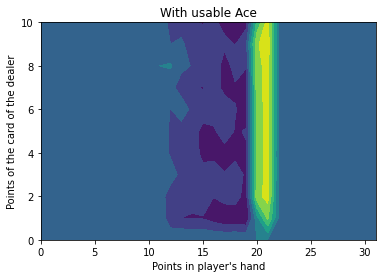

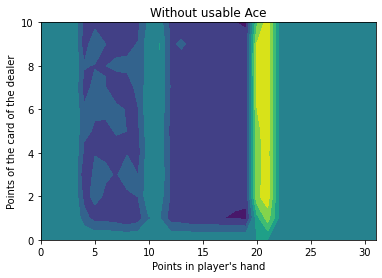

In [15]:
xx, yy, z1, z2 = visualize_policy_2d(v)

L'exemple du code ci-dessous permet de générer des graphiques en 3D pour visualiser la fonction $v$.

In [16]:
def visualize_policy_3d(xx, yy, z1, z2):
  fig = plt.figure(figsize=(7, 7))
  ax = fig.gca(projection='3d')
  ax.plot_surface(xx, yy, z1[:,:].T)
  ax.view_init(40,125)
  plt.title("with usable Ace")
  plt.xlabel("points in player's hand")
  plt.ylabel("points of the card of the dealer")
  ax.set_zlabel("value of the state")
  plt.show()

  fig = plt.figure(figsize=(7, 7))
  ax = fig.gca(projection='3d')
  ax.plot_surface(xx, yy, z2[:,:].T)
  ax.view_init(40,125)
  plt.title("without usable Ace")
  plt.xlabel("points in player's hand")
  plt.ylabel("points of the card of the dealer")
  ax.set_zlabel("value of the state")
  plt.show()

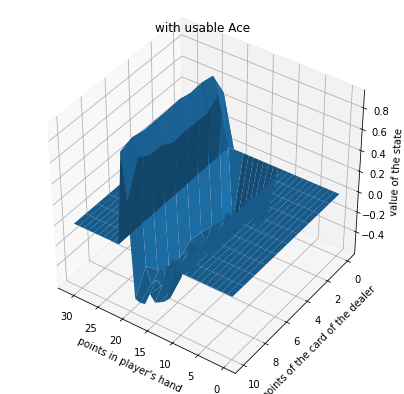

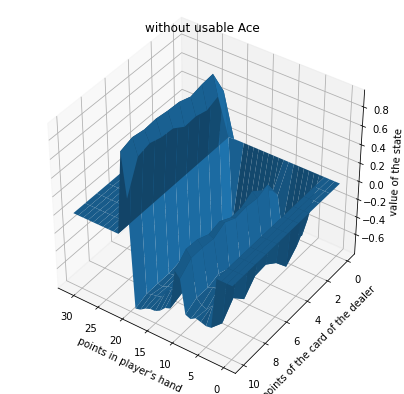

In [17]:
visualize_policy_3d(xx, yy, z1, z2)

### 2.3 Exploitation de la politique

100%|██████████| 100000/100000 [00:10<00:00, 9934.94it/s]


Mean = -0.35556


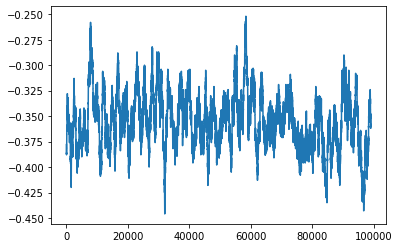

In [18]:
returns, returns_mean = exploit_and_plot(env, pi_20, gamma=1, num_episodes=100000, window_size=1000)

## <a name="sec3">3. Trouver une politique optimale (On policy MC)</a>

Avec les algorithmes "Value Iteration" ou "Policy Iteration", on aurait besoin de calculer la matrice de transition. Etant donné le nombre d'états, il serait probablement très fastidieux d'écrire cette matrice "à la main" ou bien d'écrire un programme pour calculer chaque probabilité exactement !

### 3.1 Implémentation

Le but est d'implémenter l'algorithme Monte Carlo "on policy" pour trouver la politique optimale. Une méthode "on policy" consiste à estimer et améliorer une politique tout en l'utilisant.

* Implémentez une fonction $draw(\pi)$ qui prend en paramètre une distribution de probabilités sur les actions et qui tire une action au hasard en utilisant cette distribution
* Implémentez une méthode $eps\_greedy(\epsilon, q)$ qui implémente $\epsilon$-glouton: 
  * avec une probabilité $\epsilon$, la méthode choisie une action de manière uniforme
  * avec une probabilité $1-\epsilon$, ma méthode choisie l'action qui a la plus grande valeur $q$. Si plusieurs actions ont la même valeur maximale $\max_i q(i)$, il serait bon d'en choisir une au hasard (au lieu peut-être de choisir toujours la première action qui a pour valeur $\max_i q(i)$).
* implémentez une fonction $on\_policy\_MC(env, num\_episodes, \gamma, \epsilon)$ qui implémente l'algorithme on policy Monte Carlo qui résoud de manière optimale un PDM. Votre fonction peut retourner la valeur des paires (action, etat). Les paramètres d'entrée sont 
    * num_episodes est le nombre d'épisodes utilisés pour apprendre la politique optimale
    * $\gamma$ est le taux d'escompte: on veut optimiser $\displaystyle G_t = \sum_{k=0}^\infty \gamma^k r_{t+k+1}$
    * $\epsilon$ est le paramètre pour utiliser $\epsilon$-greedy pour l'exploration
* Une fois que vous avez terminé, visualisez la politique trouvée (vous pouvez écrire dans un tableau si vous continuez ou vous vous arrêtez selon la valeur de la carte du croupier et selon la valeur de votre main (ou utiliser des couleurs). Est-ce que cette politique vous parait correcte ? En comparant avec la politique étudiée plus haut, donne-t-elle des meilleures valeurs ?

Notez qu'il serait bon d'avoir une implémentation qui puisse être générale de façon à pouvoir utiliser votre code pour d'autres environnement. En particulier dans le jeu de blackjack, on utilise $\gamma=1$, mais cela pourrait être différent pour d'autres environnement.

Si vous rencontrez des difficultés pour coder, vous pouvez dans un premier temps faire un code spécifique qui fait l'hypothèse que $\gamma=1$, voir même que vous recevez un récompense non nulle lorsque vous atteignez un état terminal. L'implémentation de ce cas est plus simple.

In [19]:
def draw(pi):
    '''Draw an action according to the probabilities pi'''

    A = list(range(len(pi))) # [0,1] dans notre cas
    action = np.random.choice(a=A, p=pi)
    return action

In [20]:
def generate_episode(env, pi, max_timesteps=100):
    episode = []
    state = env.reset()

    for t in range(max_timesteps):
        action = draw(pi[encode(state)])
        new_state, reward, done, _ = env.step(action)
        episode.append((state, action, reward))
        state = new_state
        if done:
            #print("Episode finished after {} timesteps".format(t+1))
            break
            
    return episode

In [21]:
def eps_greedy(q, s, epsilon):
    
    p = np.random.rand()
    if p > epsilon:
        winner = np.argwhere(q[s] == np.amax(q[s])).flatten().tolist()
        action = np.random.choice(winner)
    else: 
        action = np.random.choice(num_actions)
    return action

def on_policy_MC(env, num_episodes, num_states=num_states, num_actions=num_actions, epsilon=0.1, gamma=1, verbose=False):
    
    # Initialization
    q = np.zeros((num_states, num_actions))
    count = np.zeros((num_states, num_actions))
    acc = np.zeros((num_states, num_actions))
    pi = np.ones((num_states, num_actions)) / num_actions # uniform policy
    
    # Save return per episode
    episodes_return = []
    
    for i_episode in tqdm(range(num_episodes)):
        
        visited = set()

        # Generate an episode following policy pi
        episode = generate_episode(env, pi)
        T = len(episode)

        # To compute return
        G = 0 # G_T = 0
        
        # For each step in the episode...
        for t in reversed(range(T)): # From T-1 to 0
            state, action, reward = episode[t]
            i_state = encode(state)
            
            G = reward + gamma*G # G_t
            
            # Update q
            if ((i_state, action)) not in visited:
                acc[i_state, action] += G
                count[i_state, action] += 1
                q[i_state, action] = acc[i_state, action] / count[i_state, action]
                visited.add((i_state, action))
            
            # Get optimal action in state s
            action_star = np.argmax(q[i_state])

            # Update policy pi
            for a in range(num_actions):
                if a == action_star:
                    pi[i_state, a] = 1 - epsilon + epsilon/num_actions
                else:
                    pi[i_state, a] = epsilon/num_actions 
                
              
        episodes_return.append(G) # G_0
        
    return q, episodes_return, pi

### 3.2 Visualisation

In [22]:
q, returns, pi = on_policy_MC(env=env, num_episodes=100000, epsilon=0.1)

100%|██████████| 100000/100000 [00:19<00:00, 5216.92it/s]


100%|██████████| 100000/100000 [00:16<00:00, 6188.09it/s]


Mean = -0.09698


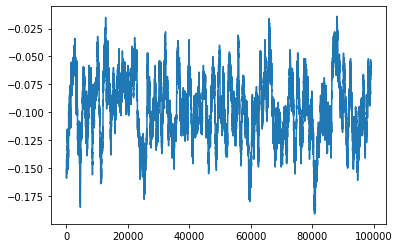

In [23]:
returns, returns_mean = exploit_and_plot(env, pi, gamma=1, num_episodes=100000, window_size=1000)

Le gain moyen est d'environ -0.09, meilleur résultat qu'avec la politique précédente dont le gain moyen était de -0.35.

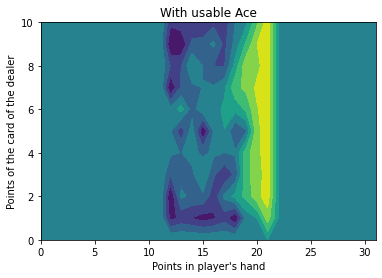

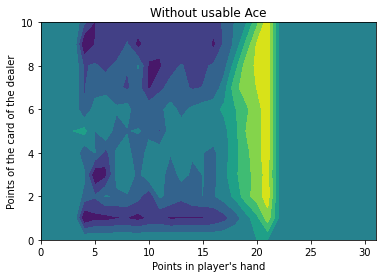

In [24]:
xx, yy, z1, z2 = visualize_policy_2d(q=q)

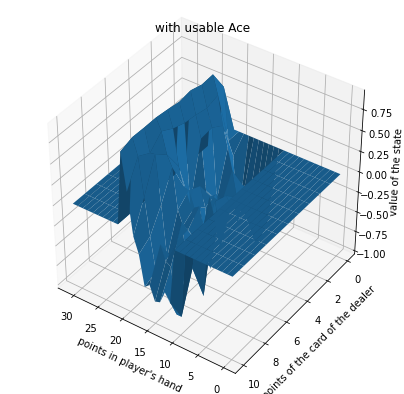

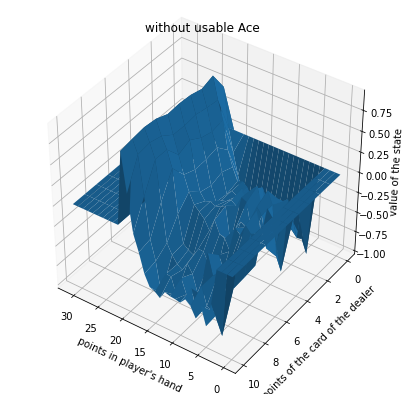

In [25]:
visualize_policy_3d(xx, yy, z1, z2)

### Bonus
Vous pouvez tester votre code sur un autre environnement simple, par exemple frozen lake. Il existe plusieurs version de cet environnement, un avec une petite grille, un autre avec une grille plus grande.  On utilisera cet environnement dans le prochain TP.


In [26]:
#env_f = gym.make("FrozenLake-v1") # Jupyter
env_f = gym.make("FrozenLake-v0") # Colab
num_actions_f = env_f.action_space.n
print("There are", num_actions_f, "actions")
print("Observation space:", env.observation_space)
num_states_f = env_f.observation_space.n
print("There are", num_states_f, "states")

There are 4 actions
Observation space: Tuple(Discrete(32), Discrete(11), Discrete(2))
There are 16 states


In [27]:
s = env_f.reset()
env_f.render()


SFFF
FHFH
FFFH
HFFG


Notez que dans cet environnement, les états sont simplement numérotés, on n'a donc plus besoin d'une fonction pour encoder ou décoder les états. 

In [28]:
def encode(state):
    return state

def decode(state):
    return state

In [38]:
q_f, rewards_f, pi_f = on_policy_MC(env_f, num_episodes=30000, epsilon=0.3, num_states=num_states_f, num_actions=num_actions_f)

100%|██████████| 30000/30000 [00:31<00:00, 964.04it/s]


100%|██████████| 30000/30000 [00:30<00:00, 998.03it/s]


Mean = 0.12896666666666667


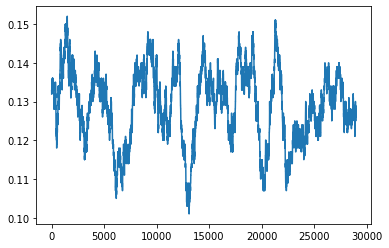

In [39]:
returns, returns_mean = exploit_and_plot(env_f, pi_f, gamma=1, num_episodes=30000, window_size=1000)

In [31]:
def plotQ(q_table, map_size):
    """Visualisation de la table Q pour FrozenLake 4x4 et 8x8.
    Passez la taille (4 ou 8) en paramètres
    """
    
    if(map_size == 4):
        MAP = [
            "SFFF",
            "FHFH",
            "FFFF",
            "HFFG"
        ]
    else:
        MAP=[
            "SFFFFFFF",
            "FFFFFFFF",
            "FFFHFFFF",
            "FFFFFHFF",
            "FFFHFFFF",
            "FHHFFFHF",
            "FHFFHFHF",
            "FFFHFFFG"
        ]
    best_value = np.max(q_table, axis=1).reshape((map_size, map_size))
    best_policy = np.argmax(q_table, axis=1).reshape((map_size, map_size))
    
    fig, ax = plt.subplots()
    im = ax.imshow(best_value)

    for i in range(best_value.shape[0]):
        for j in range(best_value.shape[1]):
            if MAP[i][j] in 'GH':
                arrow = MAP[i][j]
            elif best_policy[i, j] == 0:
                arrow = '<'
            elif best_policy[i, j] == 1:
                arrow = 'v'
            elif best_policy[i, j] == 2:
                arrow = '>'
            elif best_policy[i, j] == 3:
                arrow = '^'
            if MAP[i][j] in 'S':
                arrow = 'S ' + arrow
            text = ax.text(j, i, arrow, ha = "center", va = "center",
                         color = "black")
            
    cbar = ax.figure.colorbar(im, ax = ax)
    
    fig.tight_layout()
    plt.show()

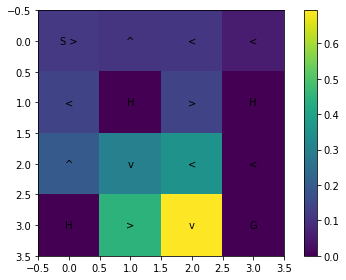

In [40]:
plotQ(q_f, 4)